In [1]:
import os
from pathlib import Path

os.environ['MMWHS_CACHE_PATH'] = str(Path('.', '.cache'))
from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
from slice_inflate.utils.common_utils import DotDict, get_script_dir

THIS_SCRIPT_DIR = get_script_dir()

In [2]:

config_dict = DotDict({
    'num_folds': 5,
    'only_first_fold': True,                # If true do not contiue with training after the first fold
    # 'fold_override': 0,
    # 'checkpoint_epx': 0,

    'use_mind': False,                      # If true use MIND features (https://pubmed.ncbi.nlm.nih.gov/22722056/)
    'epochs': 40,

    'batch_size': 8,
    'val_batch_size': 1,
    'use_2d_normal_to': 'HLA/SA',               # Can be None or 'D', 'H', 'W'. If not None 2D slices will be selected for training

    'atlas_count': 1,                       # If three (noisy) labels per image are used specify three

    'dataset': 'mmwhs',                 # The dataset prepared with our preprocessing scripts
    'data_base_path': str(Path(THIS_SCRIPT_DIR, "data/MMWHS")),
    'reg_state': None, # Registered (noisy) labels used in training. See prepare_data() for valid reg_states
    'train_set_max_len': None,              # Length to cut of dataloader sample count
    'crop_around_3d_label_center': None, #(128,128,128),
    'crop_3d_region': ((0,128), (0,128), (0,128)),        # dimension range in which 3D samples are cropped
    'crop_2d_slices_gt_num_threshold': 0,   # Drop 2D slices if less than threshold pixels are positive

    'lr': 0.01,
    'use_scheduling': True,

    'save_every': 200,
    'mdl_save_prefix': 'data/models',

    'debug': True,
    'wandb_mode': 'online',                         # e.g. online, disabled. Use weights and biases online logging
    'do_sweep': True,                                # Run multiple trainings with varying config values defined in sweep_config_dict below

    # For a snapshot file: dummy-a2p2z76CxhCtwLJApfe8xD_fold0_epx0
    'checkpoint_name': None,                          # Training snapshot name, e.g. dummy-a2p2z76CxhCtwLJApfe8xD
    'fold_override': None,                            # Training fold, e.g. 0
    'checkpoint_epx': None,                           # Training epx, e.g. 0

    'do_plot': False,                                 # Generate plots (debugging purpose)
    'save_dp_figures': False,                         # Plot data parameter value distribution
    'save_labels': True,                              # Store training labels alongside data parameter values inside the training snapshot

    'device': 'cuda'
})

config = config_dict

training_dataset = MMWHSDataset(
    config.data_base_path,
    state="training",
    load_func=load_data,
    extract_slice_func=extract_2d_data,
    modality='mr',
    do_align_global=True,
    do_resample=False, # Prior to cropping, resample image?
    crop_3d_region=None, # Crop or pad the images to these dimensions
    crop_around_3d_label_center=config.crop_around_3d_label_center,
    pre_interpolation_factor=1., # When getting the data, resize the data by this factor
    ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
    use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
    crop_around_2d_label_center=(128,128),
    device=config.device,
    debug=config.debug
)

Loading MMWHS training images and labels... (['mr'])


5 images, 5 labels: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (5)
Postprocessing 2D slices
Removed 0 of 10 2D slices in postprocessing
Nonzero 2D labels: 100.00%
Nonzero modified 2D labels: nan%
Loader will use 10 of 10 2D slices.
Data import finished.
Dataloader will yield 2D samples


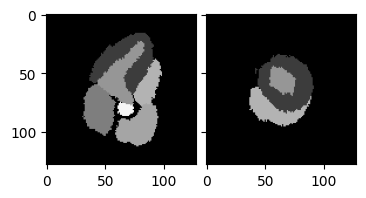

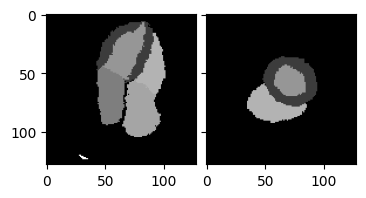

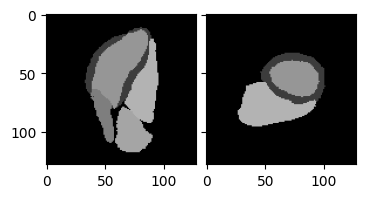

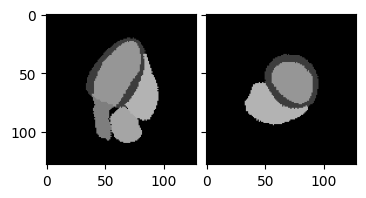

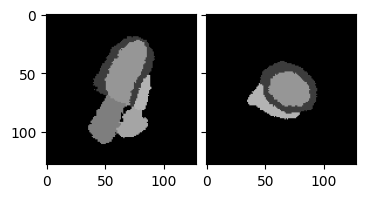

In [4]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

hla_sa_zip = zip(
    [training_dataset[idx] for idx in range(0,10,2)],
    [training_dataset[idx] for idx in range(1,10,2)]
)

for hla_sample, sa_sample in hla_sa_zip:
    fig = plt.figure(figsize=(4., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
        nrows_ncols=(1, 2),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    for ax, im in zip(grid, [hla_sample['label'], sa_sample['label']]):
        ax.imshow(im, vmax=850, cmap='gray')

    plt.show()

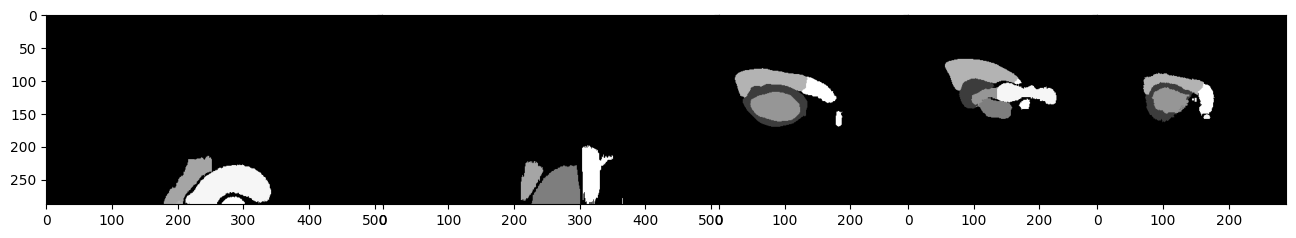

In [5]:
lbls = [training_dataset.__getitem__(idx, use_2d_override=False)['label'][:,:,64] for idx in range(5)]

fig = plt.figure(figsize=(16., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
    nrows_ncols=(1, 5),  # creates 2x2 grid of axes
    axes_pad=0.0,  # pad between axes in inch.
)

for ax, im in zip(grid, lbls):
    ax.imshow(im, vmax=850, cmap='gray')

plt.show()